In [1]:
!pip install timm

In [3]:
!pip install wandb

  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=28176c13e398d24bb6524e28809724c8cd45de1473db17f243c5586377d9a9c0
  Stored in directory: c:\users\kzvxy\appdata\local\pip\cache\wheels\29\93\c6\762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d6c246b28ea665133d371820e2956280aa7eb6c7bb4e7d431daef201d639675d
  Stored in directory: c:\users\kzvxy\appdata\local\pip\cache\wheels\3e\31\09\fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built promise pathtools


In [2]:
pip install cuml

  Using cached cuml-0.6.1.post1.tar.gz (1.1 kB)
  Running setup.py clean for cuml
Failed to build cuml
    Running setup.py install for cuml: started
    Running setup.py install for cuml: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\kzvxy\.conda\envs\test\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\kzvxy\\AppData\\Local\\Temp\\pip-install-p_d8wzeg\\cuml_085a7cc89e0e438fbbc2aadb3ee3d3b3\\setup.py'"'"'; __file__='"'"'C:\\Users\\kzvxy\\AppData\\Local\\Temp\\pip-install-p_d8wzeg\\cuml_085a7cc89e0e438fbbc2aadb3ee3d3b3\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\kzvxy\AppData\Local\Temp\pip-wheel-43vn5ak4'
       cwd: C:\Users\kzvxy\AppData\Local\Temp\pip-install-p_d8wzeg\cuml_085a7cc89e0e438fbbc2aadb3ee3d3b3\
  Complete output (25 lines):
  running bdist_wheel
  running build
  installing to build\bdist.win-amd64\wheel
  running install
  Traceback (mos

Notebook Color Scheme:


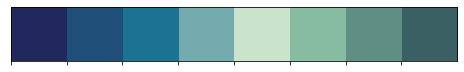

In [1]:
import os
import gc
import wandb
import time
import random
import math
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html

from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from albumentations.pytorch import transforms
import albumentations
import timm

from sklearn.neighbors import NearestNeighbors
# from cuml.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'comeptition' : 'happywhale', '_wandb_kernel':'aot'}

class clr:
    S = '\033[1m' + '\033[96m'
    E = '\033[0m'
    
my_colors = ["#21295C", "#1F4E78", "#1C7293", "#73ABAF", "#C9E4CA", "#87BBA2", "#618E83", "#3B6064"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [6]:
import wandb

wandb.init(project="happy_whale_effnet", entity="neulvo")

In [9]:
def plot_loss_graph(train_losses, valid_losses, epoch, fold):
    '''Lineplot of the training/validation losses.'''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    fig.suptitle(f"Fold {fold} | Epoch {epoch}", fontsize=12, y=1.05)
    axes = [ax1, ax2]
    data = [train_losses, valid_losses]
    sns.lineplot(y=train_losses, x=range(len(train_losses)),
                 lw=2.3, ls=":", color=my_colors[1], ax=ax1)
    sns.lineplot(y=valid_losses, x=range(len(valid_losses)),
                 lw=2.3, ls="-", color=my_colors[6], ax=ax2)
    for ax, t, d in zip(axes, ["Train", "Valid"], data):
        ax.set_title(f"{t} Evolution", size=12, weight='bold')
        ax.set_xlabel("Iteration", weight='bold', size=9)
        ax.set_ylabel("Loss", weight='bold', size=9)
        ax.tick_params(labelsize=9)
    plt.show()
    
    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='happywhale', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

In [10]:
def set_seed(seed = 1234):
    '''
    🌱src:https://www.kaggle.com/andradaolteanu/melanoma-competiton-aug-resnet-effnet-lb-0-91
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(clr.S+'Device available now:'+clr.E, device)

Device available now: cuda


In [12]:
# --------- INITIAL PARAMETERS ---------
TRAIN_FOLDER = 'C:/Users/kzvxy/pyum/kagglory/data/happy_whale/cropped_train_images/'
TEST_FOLDER = 'C:/Users/kzvxy/pyum/kagglory/data/happy_whale/cropped_test_images/'

# Set some parameters for sanity checks & experimenting
N_SPLITS = 5
BATCH_SIZE = 16
MODEL_NAME = 'efficientnet_b0'
NUM_CLASSES = 15587
NO_NEURONS = 250
EMBEDDING_SIZE = 128
# -------------------------------------

In [15]:
# Import the data
train = pd.read_csv("C:/Users/kzvxy/pyum/kagglory/data/happy_whale/train.csv")
test = pd.read_csv("C:/Users/kzvxy/pyum/kagglory/data/happy_whale/test.csv")

# Update path to new image folders
train["path"] = TRAIN_FOLDER + train["image"]
test["path"] = TEST_FOLDER + test["image"]

print(clr.S+"TRAIN:"+clr.E)
display_html(train.head())
print("\n", clr.S+"TEST:"+clr.E)
display_html(test.head())

TRAIN:


,image,species,individual_id,class,path,width,height,dimension,image_code,target,individual_key,kfold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,whale,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,804,671,539484,00021adfb725ed,['00021adfb725ed'],11473,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,whale,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,3504,2336,8185344,000562241d384d,['000562241d384d' 'ffae18d2939ffc'],4567,1
2,ffae18d2939ffc.jpg,humpback_whale,1a71fbb72250,whale,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,3504,2336,8185344,ffae18d2939ffc,['000562241d384d' 'ffae18d2939ffc'],4567,2
3,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,whale,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,3599,2399,8634001,0007c33415ce37,['0007c33415ce37' '07b8fac61777d6' '110c832238...,70,0
4,07b8fac61777d6.jpg,false_killer_whale,60008f293a2b,whale,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,2295,1404,3222180,07b8fac61777d6,['0007c33415ce37' '07b8fac61777d6' '110c832238...,70,0



 TEST:


,image,path,image_code,width,height,dimension
0,000110707af0ba.jpg,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,000110707af0ba,3599,2399,8634001
1,0006287ec424cb.jpg,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,0006287ec424cb,3600,2400,8640000
2,000809ecb2ccad.jpg,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,000809ecb2ccad,2240,1488,3333120
3,00098d1376dab2.jpg,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,00098d1376dab2,2048,892,1826816
4,000b8d89c738bd.jpg,C:/Users/kzvxy/pyum/kagglory/data/happy_whale/...,000b8d89c738bd,293,319,93467


In [16]:
class HappyWhaleDataset(Dataset):
    
    def __init__(self, csv, trainFlag):
        '''Module to create the PyTorch Dataset.
        csv: full dataframe (train or test)
        trainFlag: True if csv is a training/validation dataset, False otherwise
        return: image and class target if trainFlag, otherwise only image'''
        
        self.csv = csv
        self.trainFlag = trainFlag
        if self.trainFlag:
            self.transform = albumentations.Compose([
                albumentations.Resize(128, 128),
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip(),
                albumentations.Rotate(),
                albumentations.Normalize(),
                # B&W?
            ])
        else:
            self.transform = albumentations.Compose([
                albumentations.Normalize()
            ])

            
    def __len__(self):
        return self.csv.shape[0]

    
    def __getitem__(self, index):
        # Get data
        row = self.csv.iloc[index]
        
        # Read and transform the image
        image = cv2.imread(row.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        transformed_img = self.transform(image=image)['image'].astype(np.float32)
        image = transformed_img.transpose(2, 0, 1)
        image = torch.tensor(image)            

        if self.trainFlag:
            # Retrieve the target group
            target = torch.tensor(row.individual_key)
            return image, target
        
        else:
            return image

In [17]:
# Example for the Dataset data
example_dataset = HappyWhaleDataset(train.head(12), trainFlag=True)
example_loader = DataLoader(example_dataset, batch_size=3)

for k, (image, target) in enumerate(example_loader):
    print(clr.S+f"--- Batch {k} ---"+clr.E)
    print("Image Shape:", image.shape)
    print("Target:", target, "\n")

--- Batch 0 ---
Image Shape: torch.Size([3, 3, 128, 128])
Target: tensor([11473,  4567,  4567]) 

--- Batch 1 ---
Image Shape: torch.Size([3, 3, 128, 128])
Target: tensor([70, 70, 70]) 

--- Batch 2 ---
Image Shape: torch.Size([3, 3, 128, 128])
Target: tensor([70, 70, 70]) 

--- Batch 3 ---
Image Shape: torch.Size([3, 3, 128, 128])
Target: tensor([70, 70, 70]) 



In [18]:
# src: https://amaarora.github.io/2020/08/30/gempool.html

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        # Applies 2D average-pooling operation in kH * kW regions by step size
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [19]:
# src: https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        '''
        in_features: dimension of the input
        out_features: dimension of the last layer (in our case the classification)
        s: norm of input feature
        m: margin
        ls_eps: label smoothing'''
        
        super(ArcMarginProduct, self).__init__()
        self.in_features, self.out_features = in_features, out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        # Fills the input `Tensor` with values according to the method described in
        # `Understanding the difficulty of training deep feedforward neural networks`
        # Glorot, X. & Bengio, Y. (2010)
        # using a uniform distribution.
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m, self.sin_m = math.cos(m), math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        one_hot = torch.zeros(cosine.size()).to(device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [20]:
class HappyWhaleModel(nn.Module):
    def __init__(self, modelName, numClasses, noNeurons, embeddingSize):
        
        super(HappyWhaleModel, self).__init__()
        # Retrieve pretrained weights
        self.backbone = timm.create_model(modelName, pretrained=True)
        # Save the number features from the backbone
        ### different models have different numbers e.g. EffnetB3 has 1536
        backbone_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity() # ?????
        self.backbone.global_pool = nn.Identity() # ?????
        self.gem = GeM()
        # Embedding layer (what we actually need)
        self.embedding = nn.Sequential(nn.Linear(backbone_features, noNeurons),
                                       nn.BatchNorm1d(noNeurons),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.2),
                                       
                                       nn.Linear(noNeurons, embeddingSize),
                                       nn.BatchNorm1d(embeddingSize),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.2))
        self.arcface = ArcMarginProduct(in_features=embeddingSize, 
                                        out_features=numClasses,
                                        s=30.0, m=0.50, easy_margin=False, ls_eps=0.0)
        
        
    def forward(self, image, target=None, prints=False):
        '''If there is a target it means that the model is training on the dataset.
        If there is no target, that means the model is predicting on the test dataset.
        In this case we would skip the ArcFace layer and return only the image embeddings.
        '''
        
        features = self.backbone(image)
        # flatten transforms from e.g.: [3, 1536, 1, 1] to [3, 1536]
        gem_pool = self.gem(features).flatten(1)
        embedding = self.embedding(gem_pool)
        if target != None:
            out = self.arcface(embedding, target)
        
        if prints:
            print(clr.S+"0. IN:", "image shape:"+clr.E, image.shape, "target:", target)
            print(clr.S+"1. Backbone Output:"+clr.E, features.shape)
            print(clr.S+"2. GeM Pool Output:"+clr.E, gem_pool.shape)
            print(clr.S+"3. Embedding Output:"+clr.E, embedding.shape)
            if target != None:
                print(clr.S+"4. ArcFace Output:"+clr.E, out.shape)
        
        if target != None:
            return out, embedding
        else:
            return embedding

In [21]:
# Create an example model - Effnet
model_example = HappyWhaleModel(MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE).to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to C:\Users\kzvxy/.cache\torch\hub\checkpoints\efficientnet_b0_ra-3dd342df.pth


In [22]:
# Criterion
criterion_example = nn.CrossEntropyLoss()

# We'll use previous datasets & dataloader
for k, (image, target) in enumerate(example_loader):
    print(clr.S+f"=== Batch {k} ==="+clr.E)
    image, target = image.to(device), target.to(device)
    out, _ = model_example(image, target, prints=True)
    loss = criterion_example(out, target)
    print(clr.S+'--- LOSS ---'+clr.E, loss.item(), "\n")

=== Batch 0 ===
0. IN: image shape: torch.Size([3, 3, 128, 128]) target: tensor([11473,  4567,  4567], device='cuda:0')
1. Backbone Output: torch.Size([3, 1280, 4, 4])
2. GeM Pool Output: torch.Size([3, 1280])
3. Embedding Output: torch.Size([3, 128])
4. ArcFace Output: torch.Size([3, 15587])
--- LOSS --- 28.47798728942871 

=== Batch 1 ===
0. IN: image shape: torch.Size([3, 3, 128, 128]) target: tensor([70, 70, 70], device='cuda:0')
1. Backbone Output: torch.Size([3, 1280, 4, 4])
2. GeM Pool Output: torch.Size([3, 1280])
3. Embedding Output: torch.Size([3, 128])
4. ArcFace Output: torch.Size([3, 15587])
--- LOSS --- 28.244943618774414 

=== Batch 2 ===
0. IN: image shape: torch.Size([3, 3, 128, 128]) target: tensor([70, 70, 70], device='cuda:0')
1. Backbone Output: torch.Size([3, 1280, 4, 4])
2. GeM Pool Output: torch.Size([3, 1280])
3. Embedding Output: torch.Size([3, 128])
4. ArcFace Output: torch.Size([3, 15587])
--- LOSS --- 28.453590393066406 

=== Batch 3 ===
0. IN: image shape:

In [23]:
del model_example
gc.collect()

178

In [24]:
def get_loaders(df, train_i, valid_i):
    '''
    df: the full initial dataframe
    train_i, valid_i: list of indexes for train and validation split
    VALID_PERC: percentage of how much of valid data to preserve - leave 1 for full dataset
    return: train_loader and valid_loader
    '''
    
    train_df = df.iloc[train_i, :]
    # To go quicker through validation
    valid_df = df.iloc[valid_i, :].sample(int(len(valid_i)*VALID_PERC), random_state=23)

    # Datasets & Dataloader
    train_dataset = HappyWhaleDataset(train_df, trainFlag=True)
    valid_dataset = HappyWhaleDataset(valid_df, trainFlag=True)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, valid_loader

In [25]:
def get_model_optimizer_criterion():
    
    model = HappyWhaleModel(MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE).to(device)
    optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, amsgrad=False)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=MIN_LR)
    criterion = nn.CrossEntropyLoss()
    
    return model, optimizer, scheduler, criterion

In [26]:
def train_pipeline(train):
    '''
    train: the full training dataframe (to be split in train data & valid data)
    '''

    s = time.time()
    
    # 🐝 W&B Initialize  
    RUN_CONFIG = CONFIG.copy()
    params = dict(model=MODEL_NAME, epochs=EPOCHS, split=N_SPLITS, 
                  batch=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
                  t_max=T_MAX, min_lr=MIN_LR)
    RUN_CONFIG.update(params)
    run = wandb.init(project='happywhale', name=RUN_NAME, config=RUN_CONFIG)

    
    # === CV Split ===
    skf = StratifiedKFold(n_splits=N_SPLITS)
    skf_splits = skf.split(X=train, y=train["individual_key"])


    for fold, (train_i, valid_i) in enumerate(skf_splits):

        print("~"*25)
        print("~"*8, clr.S+f"FOLD {fold}"+clr.E, "~"*8)
        print("~"*25)

        # Retrieve data loaders
        train_loader, valid_loader = get_loaders(train, train_i, valid_i)

        # Model/ Optimizer/ Scheduler/ Criterion
        model, optimizer, scheduler, criterion = get_model_optimizer_criterion()
        # Hooks into the torch model to collect gradients and the topology
        wandb.watch(model, log_freq=100)

        # Run Training
        BEST_SCORE = 9999

        for epoch in range(EPOCHS):
            print("~"*8, clr.S+f"Epoch {epoch}"+clr.E, "~"*8)

            # === TRAIN ===
            model.train()
            train_losses = []

            for images, targets in tqdm(train_loader, desc = 'TRAIN'):
                images, targets = images.to(device), targets.to(device)

                # Clear gradients BEFORE prediction
                optimizer.zero_grad()
                # Make predictions
                out, _ = model(images, targets)
                # Compute Loss and Optimize
                loss = criterion(out, targets)             
                loss.backward()
                optimizer.step()

                train_losses.append(loss.cpu().detach().numpy().tolist())

            # Adjust Learning Rate
            scheduler.step()

            mean_train_loss = np.mean(train_losses)
            print(clr.S+"Mean Train Loss:"+clr.E, mean_train_loss)
            wandb.log({"mean_train_loss": np.float(mean_train_loss)}, step=epoch)


            # === EVAL ===
            model.eval()
            valid_losses, valid_preds, valid_targets = [], [], []
            with torch.no_grad():
                for images, targets in valid_loader:
                    valid_targets.append(targets)
                    images, targets = images.to(device), targets.to(device)

                    out, _ = model(images, targets)
                    loss = criterion(out, targets)

                    valid_preds.append(out)
                    valid_losses.append(loss.cpu().detach().numpy().tolist())

            mean_valid_loss = np.mean(valid_losses)
            print(clr.S+"Mean Valid Loss:"+clr.E, mean_valid_loss)
            wandb.log({"mean_valid_loss": np.float(mean_valid_loss)}, step=epoch)
            gc.collect()

            plot_loss_graph(train_losses, valid_losses, epoch, fold)
            create_wandb_plot(x_data=range(len(train_losses)), y_data=train_losses,
                      x_name="Iterations", y_name="Loss", title="Train Loss",
                      log="train_loss", plot="line")

            # === UPDATES ===

            if mean_valid_loss < BEST_SCORE:        
                print("! Saving model in fold {} | epoch {} ...".format(fold, epoch), "\n")
                torch.save(model.state_dict(), f"C:/Users/kzvxy/pyum/kagglory/data/happy_whale/model/EffNetB0_fold_{fold}_loss_{round(mean_valid_loss, 3)}.pt")

                BEST_SCORE = mean_valid_loss

        # Clean memory before next fold
        del model, optimizer, scheduler, criterion, images, targets, \
                    train_losses, valid_losses, valid_preds, valid_targets
        torch.cuda.empty_cache()
        gc.collect()


    print(clr.S+f"Time to run: {round((time.time() - s)/60, 2)} minutes"+clr.E)
    wandb.finish()

In [27]:
# --------- GLOBAL PARAMETERS ---------
NUM_CLASSES = 15587
N_SPLITS = 3
BATCH_SIZE = 32
MODEL_NAME = 'efficientnet_b0'
RUN_NAME = "B0_neurons_200_embed_200_epochs_4"
EPOCHS = 6
VALID_PERC = 0.1
NO_NEURONS = 250
EMBEDDING_SIZE = 128
# -> Optimizer
LR = 0.0001
WEIGHT_DECAY = 0.000001
# -> Scheduler
T_MAX = 500              # Maximum number of iterations
MIN_LR = 0.000001        # Minimum learning rate. Default: 0
# ------------------------------------


~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~ FOLD 0 ~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~ Epoch 0 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [04:42<00:00,  3.77it/s]


Mean Train Loss: 22.545587794225018
Mean Valid Loss: 17.27438552291305


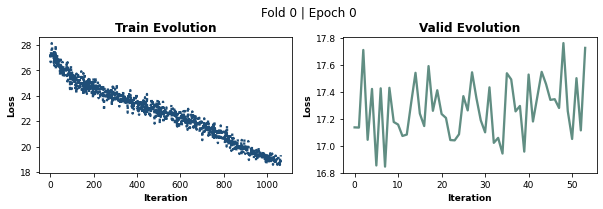

! Saving model in fold 0 | epoch 0 ... 

~~~~~~~~ Epoch 1 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:04<00:00,  5.77it/s]


Mean Train Loss: 16.966418582693976
Mean Valid Loss: 15.094057418681958


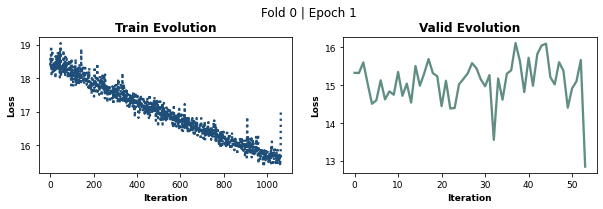

! Saving model in fold 0 | epoch 1 ... 

~~~~~~~~ Epoch 2 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:04<00:00,  5.76it/s]


Mean Train Loss: 14.864452001743746
Mean Valid Loss: 16.384842731334544


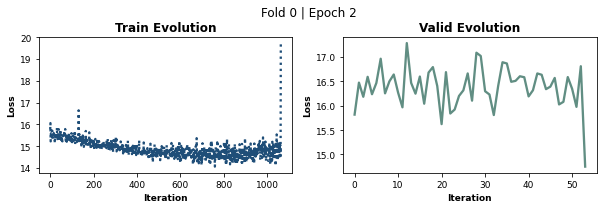

~~~~~~~~ Epoch 3 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:07<00:00,  5.67it/s]


Mean Train Loss: 14.925546405010653
Mean Valid Loss: 16.360028920350253


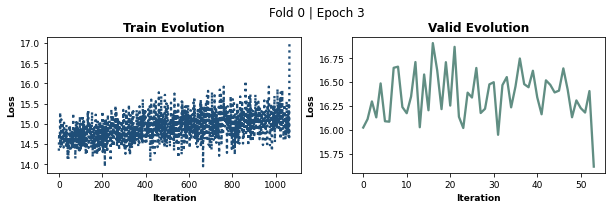

~~~~~~~~ Epoch 4 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:04<00:00,  5.76it/s]


Mean Train Loss: 15.106221477788194
Mean Valid Loss: 16.409989833831787


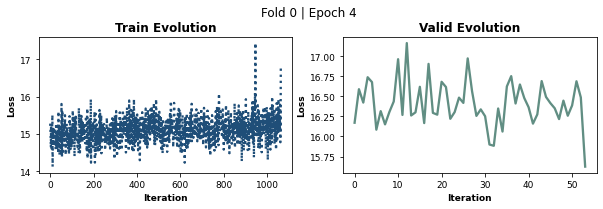

~~~~~~~~ Epoch 5 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:05<00:00,  5.73it/s]


Mean Train Loss: 15.143296441637483
Mean Valid Loss: 16.46742176126551


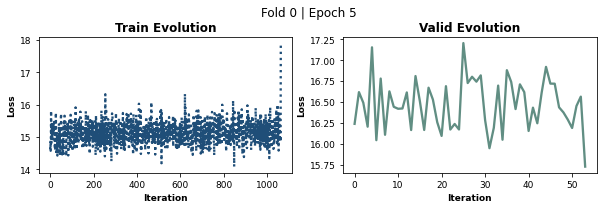

~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~ FOLD 1 ~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~ Epoch 0 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:58<00:00,  4.46it/s]


Mean Train Loss: 22.439097194743336
Mean Valid Loss: 17.43537245856391


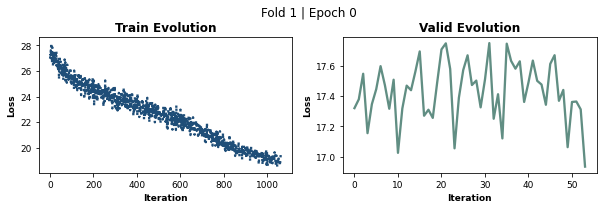

! Saving model in fold 1 | epoch 0 ... 

~~~~~~~~ Epoch 1 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:03<00:00,  5.81it/s]


Mean Train Loss: 17.097531572320406
Mean Valid Loss: 15.080206058643482


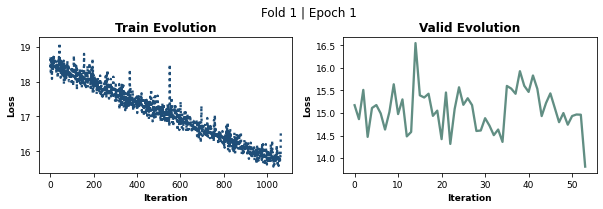

! Saving model in fold 1 | epoch 1 ... 

~~~~~~~~ Epoch 2 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:06<00:00,  5.71it/s]


Mean Train Loss: 14.90101158708558
Mean Valid Loss: 16.25881647180628


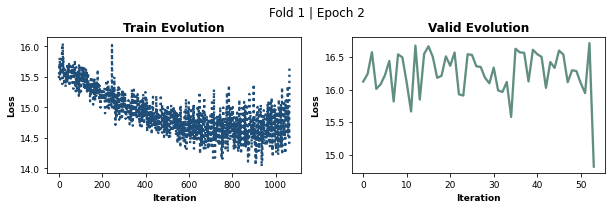

~~~~~~~~ Epoch 3 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:05<00:00,  5.73it/s]


Mean Train Loss: 14.928939567472701
Mean Valid Loss: 16.4105459495827


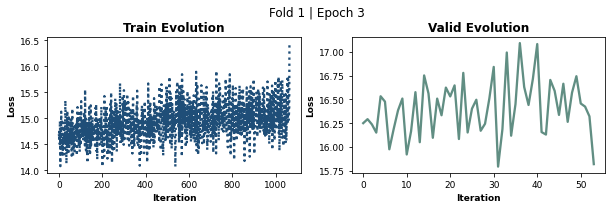

~~~~~~~~ Epoch 4 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:05<00:00,  5.75it/s]


Mean Train Loss: 15.120641303241701
Mean Valid Loss: 16.310274883552832


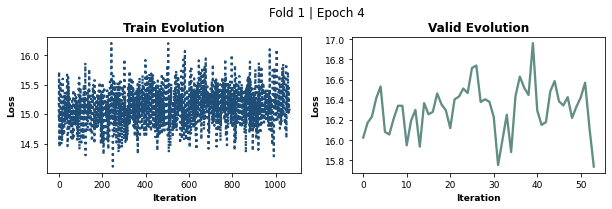

~~~~~~~~ Epoch 5 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:02<00:00,  5.84it/s]


Mean Train Loss: 15.140680480720405
Mean Valid Loss: 16.40464198147809


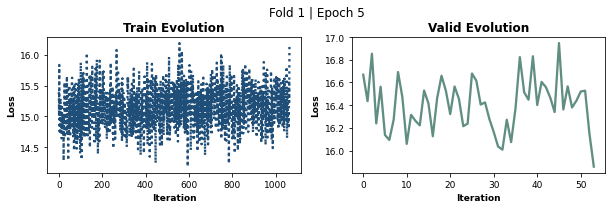

~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~ FOLD 2 ~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~ Epoch 0 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:02<00:00,  5.82it/s]


Mean Train Loss: 22.424723580367584
Mean Valid Loss: 17.078721152411568


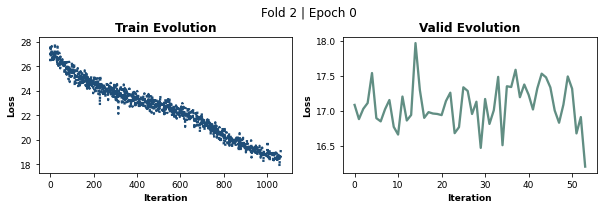

! Saving model in fold 2 | epoch 0 ... 

~~~~~~~~ Epoch 1 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:05<00:00,  5.73it/s]


Mean Train Loss: 16.710286522270145
Mean Valid Loss: 15.047237943719935


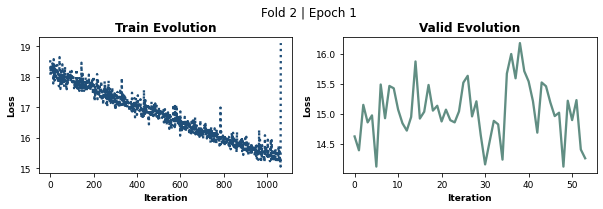

! Saving model in fold 2 | epoch 1 ... 

~~~~~~~~ Epoch 2 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:06<00:00,  5.70it/s]


Mean Train Loss: 14.769338747612515
Mean Valid Loss: 16.278034810666686


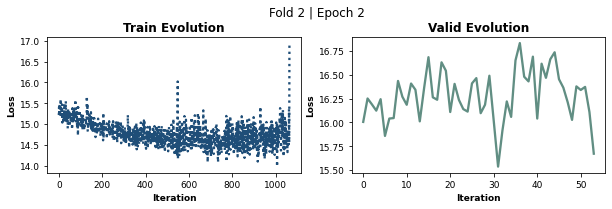

~~~~~~~~ Epoch 3 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:03<00:00,  5.81it/s]


Mean Train Loss: 14.944312882602663
Mean Valid Loss: 16.39349995719062


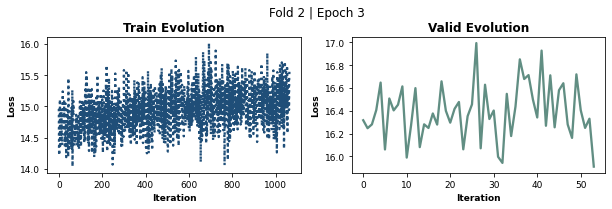

~~~~~~~~ Epoch 4 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:05<00:00,  5.73it/s]


Mean Train Loss: 15.112108175019573
Mean Valid Loss: 16.38482650121053


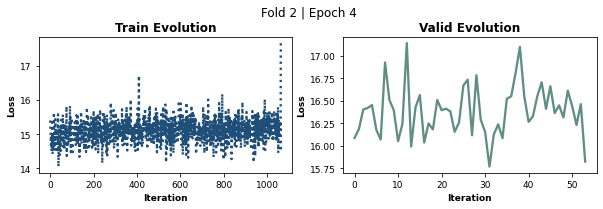

~~~~~~~~ Epoch 5 ~~~~~~~~


TRAIN: 100%|███████████████████████████████████████████████████████████████████████| 1064/1064 [03:05<00:00,  5.73it/s]


Mean Train Loss: 15.135720867859689
Mean Valid Loss: 16.377937087306268


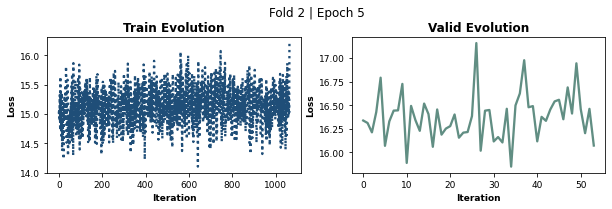

Time to run: 60.77 minutes



In [28]:
train_pipeline(train)

In [30]:
# pretrained_name = "EffNetB0_fold_0_loss_14.979"
# pretrained_name = "EffNetB0_fold_1_loss_14.91"
pretrained_name = "EffNetB0_fold_2_loss_15.047"

# Path to trained model parameters (i.e. weights and biases)
classif_model_path = f"C:/Users/kzvxy/pyum/kagglory/data/happy_whale/model/{pretrained_name}.pt"

# Load the model and append learned params
model = HappyWhaleModel(MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE).to(device)
model.load_state_dict(torch.load(classif_model_path))

<All keys matched successfully>

In [31]:
# DataLoader
dataset = HappyWhaleDataset(train, trainFlag=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Retrieve all embeddings for each image
all_embeddings = []

model.eval()
with torch.no_grad():
    for image, target in tqdm(dataloader): 
        image, target = image.to(device), target.to(device)
        _, embedding = model(image, target)
        embedding = embedding.detach().cpu().numpy()
        all_embeddings.append(embedding)
        
# Concatenate batches together
image_embeddings = np.concatenate(all_embeddings)

# Save embeddings and corresponding image
np.save(f'C:/Users/kzvxy/pyum/kagglory/data/happy_whale/model/{pretrained_name}.npy', image_embeddings)

100%|████████████████████████████████████████████████████████████████████████████████| 798/798 [03:35<00:00,  3.70it/s]


In [33]:
# 🐝Save embeddings to W&B
save_dataset_artifact(run_name=pretrained_name, 
                      artifact_name=pretrained_name, 
                      path="C:/Users/kzvxy/pyum/kagglory/data/happy_whale/model/EffNetB0_fold_2_loss_15.047.npy")



Artifact has been saved successfully.


In [34]:
# === CLUSTERING ===
# Use the cuml function from RAPIDS suite
knn_model = NearestNeighbors(n_neighbors=5)
# Train the model
knn_model.fit(image_embeddings)

# Infer on the training data
# distances - the distance between each point in the group
# indices - the index row of each image
distances, indices = knn_model.kneighbors(image_embeddings)

In [35]:
# === PREDICTION ===
# Create the grouped predictions based on distances & indices
predictions = {"images": [], "embeddings": []}

for i in tqdm(range(len(image_embeddings))):
    index = np.where(distances[k, ] < 6.0)[0]
    split = indices[i, index]
    
    grouped_images = train.iloc[split]["image"].values
    grouped_embeddings = image_embeddings[split]

    predictions["images"].append(grouped_images)
    predictions["embeddings"].append(grouped_embeddings)

100%|██████████████████████████████████████████████████████████████████████████| 51033/51033 [00:06<00:00, 7425.64it/s]


In [37]:
def get_cosine_similarity(embeddings):
    '''Compute cos distance between n embedding vector and itself.'''
    similarity_matrix = []
    
    for embed1 in embeddings:
        similarity_row = []
        for embed2 in embeddings:
            similarity_row.append(1 - spatial.distance.cosine(embed1, embed2))
        similarity_matrix.append(similarity_row)
    
    return np.array(similarity_matrix, dtype="float32")


def plot_heatmap(example_paths, cos_matrix, mask):
    '''Computes cos distance heatmap.'''
    
    # Plots
    fig = plt.figure(figsize=(12, 12))
    ax1 = plt.subplot2grid(shape=(6, 6), loc=(5, 1), colspan=1)
    ax2 = plt.subplot2grid(shape=(6, 6), loc=(5, 2), colspan=1)
    ax3 = plt.subplot2grid(shape=(6, 6), loc=(5, 3), colspan=1)
    ax4 = plt.subplot2grid(shape=(6, 6), loc=(5, 4), colspan=1)
    ax5 = plt.subplot2grid(shape=(6, 6), loc=(5, 5), colspan=1)
    h_axes = [ax1, ax2, ax3, ax4, ax5]

    ax6 = plt.subplot2grid(shape=(6, 6), loc=(0, 0), colspan=1)
    ax7 = plt.subplot2grid(shape=(6, 6), loc=(1, 0), colspan=1)
    ax8 = plt.subplot2grid(shape=(6, 6), loc=(2, 0), colspan=1)
    ax9 = plt.subplot2grid(shape=(6, 6), loc=(3, 0), colspan=1)
    ax10 = plt.subplot2grid(shape=(6, 6), loc=(4, 0), colspan=1)
    v_axes = [ax6, ax7, ax8, ax9, ax10]

    ax11 = plt.subplot2grid(shape=(6, 6), loc=(0, 1), colspan=5, rowspan=5)

    fig.suptitle('- Cosine Distance -', size = 21, color = my_colors[7], weight='bold')
    for k, ax in enumerate(h_axes):
        ax.imshow(plt.imread(example_paths[k]))
        ax.set_axis_off()

    for k, ax in enumerate(v_axes):
        ax.imshow(plt.imread(example_paths[k]))
        ax.set_axis_off()

    sns.heatmap(cos_matrix, ax=ax11, fmt=".5",
                cbar=False, annot=True, linewidths=0.5, mask=mask, square=True, cmap="winter_r")

    plt.tight_layout()
    plt.show();

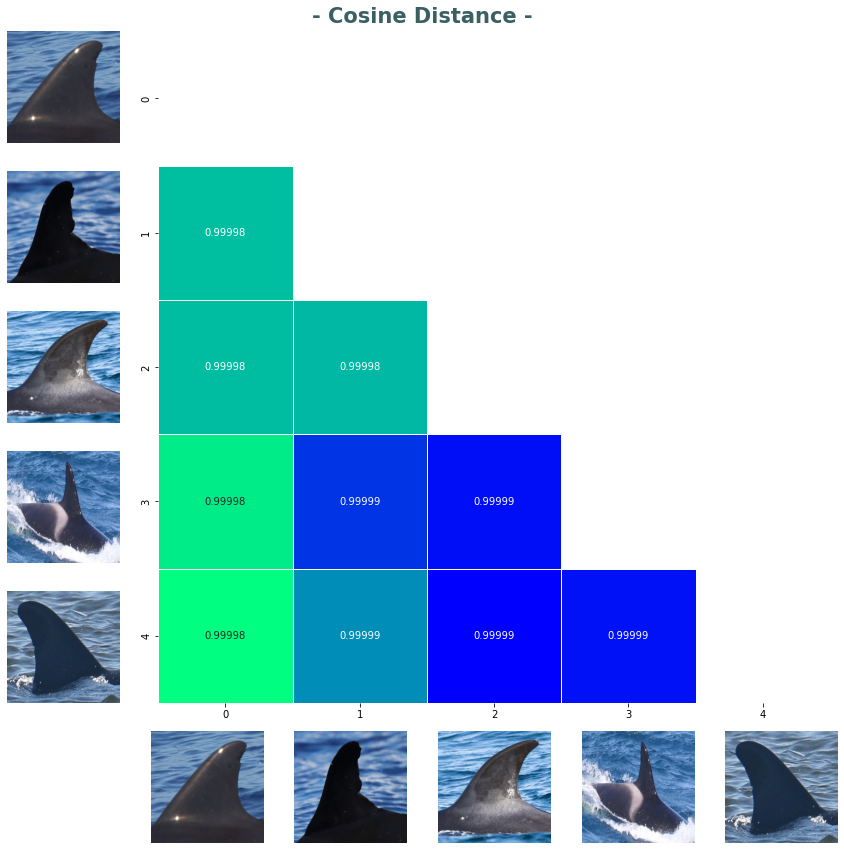

In [38]:
# Select a clustered group
group = 0

example_paths = ["C:/Users/kzvxy/pyum/kagglory/data/happy_whale/cropped_train_images/"+img \
                     for img in predictions["images"][group]]
example_embeds = predictions["embeddings"][group]

# Compute similarity matrix
cos_matrix = get_cosine_similarity(example_embeds)
mask = np.zeros_like(cos_matrix)
mask[np.triu_indices_from(mask)] = True

plot_heatmap(example_paths, cos_matrix, mask)

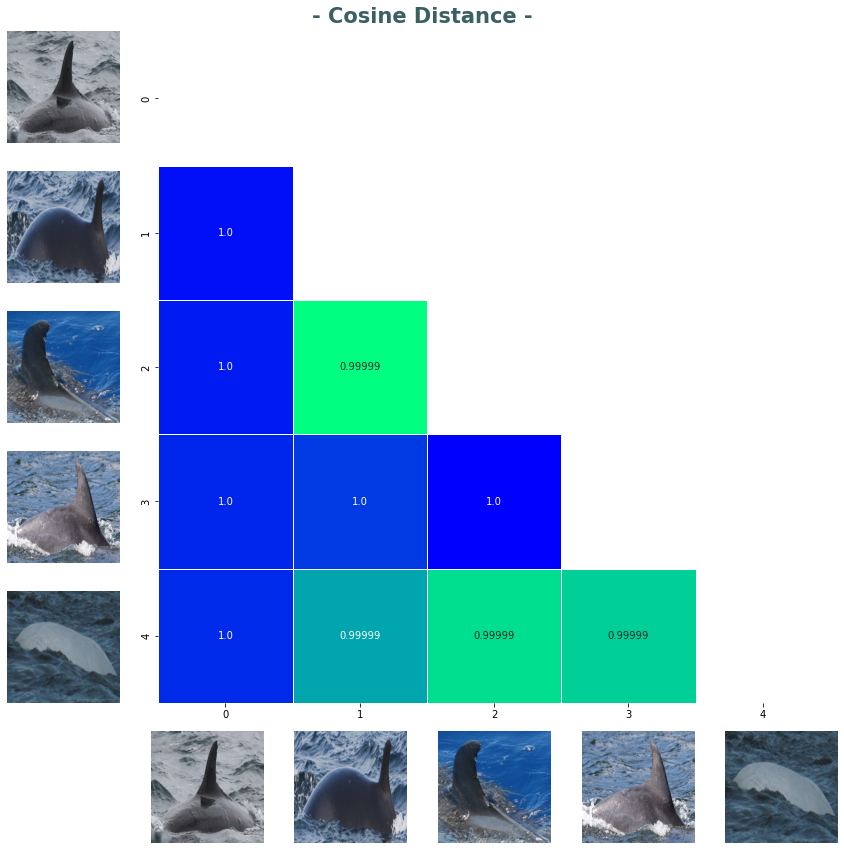

In [39]:
# Select a clustered group
group = 24

example_paths = ["C:/Users/kzvxy/pyum/kagglory/data/happy_whale/cropped_train_images/"+img \
                     for img in predictions["images"][group]]
example_embeds = predictions["embeddings"][group]

# Compute similarity matrix
cos_matrix = get_cosine_similarity(example_embeds)
mask = np.zeros_like(cos_matrix)
mask[np.triu_indices_from(mask)] = True

plot_heatmap(example_paths, cos_matrix, mask)

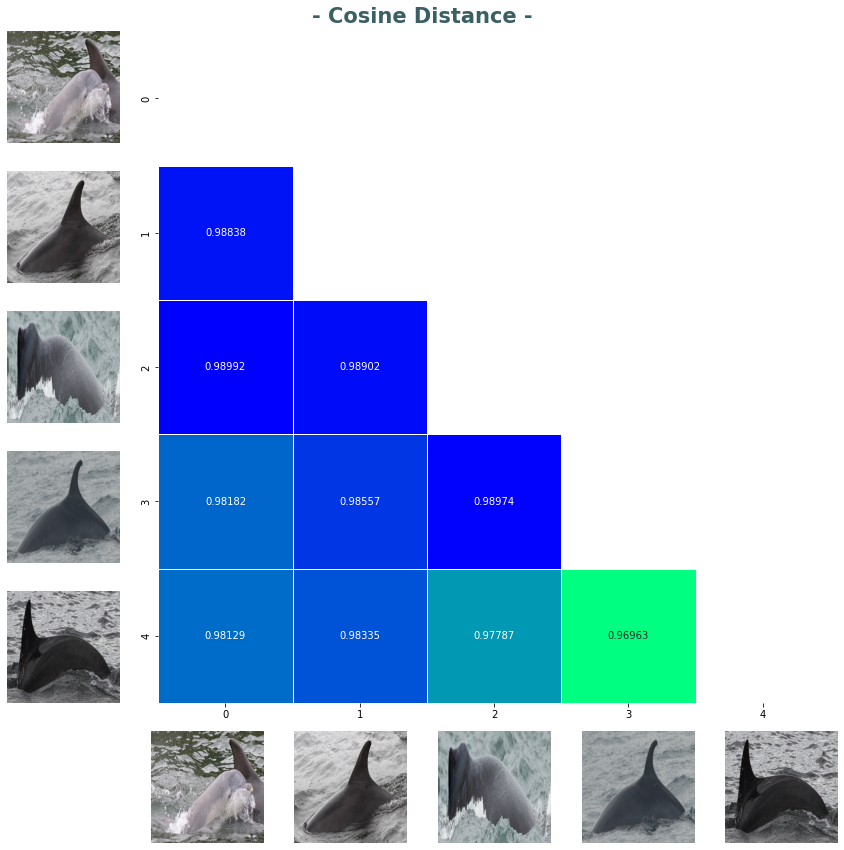

In [40]:
# Select a clustered group
group = 100

example_paths = ["C:/Users/kzvxy/pyum/kagglory/data/happy_whale/cropped_train_images/"+img \
                     for img in predictions["images"][group]]
example_embeds = predictions["embeddings"][group]

# Compute similarity matrix
cos_matrix = get_cosine_similarity(example_embeds)
mask = np.zeros_like(cos_matrix)
mask[np.triu_indices_from(mask)] = True

plot_heatmap(example_paths, cos_matrix, mask)

In [48]:
# --------- INFERENCE PARAMETERS ---------
PRETRAINED_NAME1 = "EffNetB0_fold_2_loss_15.047"
PRETRAINED_NAME2 = "EffNetB0_fold_1_loss_15.08"
PRETRAINED_NAME3 = "EffNetB0_fold_0_loss_15.094"
MODEL_NAME = 'efficientnet_b0'
NUM_CLASSES = 15587
NO_NEURONS = 250
EMBEDDING_SIZE = 128
# ----------------------------------------

In [49]:
def retrieve_test_embeddings(PRETRAINED_NAME, MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE):
    '''Get test embeddings using a pretrained model.'''
    
    # Path to [best] model
    classif_model_path = f"C:/Users/kzvxy/pyum/kagglory/data/happy_whale/model/{PRETRAINED_NAME}.pt"

    # Load the model and append learned params
    final_model = HappyWhaleModel(MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE).to(device)
    final_model.load_state_dict(torch.load(classif_model_path))

    # DataLoader
    dataset = HappyWhaleDataset(test, trainFlag=False)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    # Retrieve test embeddings from the model
    all_embeddings = []

    final_model.eval()
    with torch.no_grad():
        for image in tqdm(dataloader): 
            image = image.to(device)
            embedding = final_model(image, target=None)
            embedding = embedding.detach().cpu().numpy()
            all_embeddings.append(embedding)

    # Concatenate batches together
    test_embeddings = np.concatenate(all_embeddings)

    # Save embeddings
    np.save(f'{PRETRAINED_NAME}_test_.npy', test_embeddings)
    
    return test_embeddings

In [50]:
# ===== I. EMBEDDINGS  =====
# Here I am retrieving the 3 test embeddings and averaging them together
test_embeddings1 = retrieve_test_embeddings(PRETRAINED_NAME1, 
                                            MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE)
test_embeddings2 = retrieve_test_embeddings(PRETRAINED_NAME2, 
                                            MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE)
test_embeddings3 = retrieve_test_embeddings(PRETRAINED_NAME3, 
                                            MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE)

test_embeddings = (test_embeddings1+test_embeddings2+test_embeddings3)/3

100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [04:51<00:00,  1.50it/s]


In [53]:
# ===== II. CLUSTERS  =====
# Get full train embeddings
# Here I am adding the 3 train embeddings and averaging them together as well
train_embeddings1 = np.load(f"C:/Users/kzvxy/pyum/kagglory/data/happy_whale/model/{PRETRAINED_NAME1}_test_.npy")
train_embeddings2 = np.load(f"C:/Users/kzvxy/pyum/kagglory/data/happy_whale/model/{PRETRAINED_NAME2}_test_.npy")
train_embeddings3 = np.load(f"C:/Users/kzvxy/pyum/kagglory/data/happy_whale/model/{PRETRAINED_NAME3}_test_.npy")

train_embeddings = (train_embeddings1+train_embeddings2+train_embeddings3)/3

train_individual_ids = train["individual_id"].values
print(clr.S+"Train Embeddings:"+clr.E, train_embeddings.shape, "\n"+
      clr.S+"Train Individual Id:"+clr.E, train_individual_ids.shape, "\n")


# Train a final KNN model with the train embeddings
knn_final_model = NearestNeighbors(n_neighbors=50)
knn_final_model.fit(train_embeddings)

# Get distances & indexes for test
# test_embeddings = normalize(test_embeddings, axis=1, norm='l2')

D, I = knn_final_model.kneighbors(test_embeddings)
print(clr.S+"Distances shape:"+clr.E, D.shape, "\n"+
      clr.S+"Index shape:"+clr.E, I.shape)

# List of the test dataframe image ids (to loop through it)
test_images = test["image"].tolist()

Train Embeddings: (27956, 128) 
Train Individual Id: (51033,) 

Distances shape: (27956, 50) 
Index shape: (27956, 50)


In [54]:
test_df = []

# Loop through each observation within test data
for k, image_id in tqdm(enumerate(test_images)):
    # Get individual_id & distances for the observation
    individual_id = train_individual_ids[I[k]]
    distances = D[k]
    # Create a df subset with this info
    subset_preds = pd.DataFrame(np.stack([individual_id, distances], axis=1),
                                columns=['individual_id','distances'])
    subset_preds['image_id'] = image_id
    test_df.append(subset_preds)
    
    
# Concatenate subset dataframes into 1 dataframe
test_df = pd.concat(test_df).reset_index(drop=True)
# Choose max distance for each unique pair of individual_id & image_id
test_df = test_df.groupby(['image_id','individual_id'])['distances'].max().reset_index()

27956it [00:10, 2670.58it/s]


In [55]:
# Have a look at the predictions dataset now
test_df.sample(n=5, random_state=24)

,image_id,individual_id,distances
850593,a2449af63986f7.jpg,9f3613b5c45b,0.010392
1267081,f257a0eeae07da.jpg,8d1375f18760,0.012452
199310,24edb5261d4749.jpg,dbc18c7c5856,0.011004
1240545,ed4a90982e4a5b.jpg,1138a9024ee5,0.009755
1333359,fe70274a8d4491.jpg,15d96d5d42c2,0.009470


In [56]:
# ===== III. PREDICTION  =====

# Dictionary in format: {["image_id"]: 000, ["individual_id"]: 9999}
predictions = {}
thresh = 5

for k, row in tqdm(test_df.iterrows()):
    image_id = row["image_id"]
    individual_id = row["individual_id"]
    distance = row["distances"]
    
    # If the image_id has already been added in predictions before
    if image_id in predictions:
        # If total preds for this image_id are < 5 then add, else continue
        if len(predictions[image_id]) != 5:
            predictions[image_id].append(individual_id)
        else:
            continue
    # If the distance is greater than thresh add prediction + "new_individual"
    elif distance > thresh:
        predictions[image_id] = [individual_id, "new_individual"]
    else:
        predictions[image_id] = ["new_individual", individual_id]


# Fill in all lists that have less than 5 predictions as of yet
sample_list = ['37c7aba965a5', '114207cab555', 'a6e325d8e924', '19fbb960f07d','c995c043c353']

for image_id, preds in tqdm(predictions.items()):
    if len(preds) < 5:
        remaining = [individ_id for individ_id in sample_list if individ_id not in preds]
        preds.extend(remaining)
        predictions[image_id] = preds[:5]

1341126it [00:58, 22829.06it/s]
100%|███████████████████████████████████████████████████████████████████████| 27956/27956 [00:00<00:00, 3493712.01it/s]


In [57]:
# Create final submission
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions['predictions'] = predictions['predictions'].apply(lambda x: ' '.join(x))
predictions.to_csv('C:/Users/kzvxy/pyum/kagglory/data/happy_whale/submission.csv',index=False)

predictions.head()

,image,predictions
0,000110707af0ba.jpg,new_individual 02947a94c3fc 09cb24d1340f 0c7ef...
1,0006287ec424cb.jpg,new_individual 02940e2f032b 07a477b6a091 19b63...
2,000809ecb2ccad.jpg,new_individual 03eaca1e8a5e 06ef73efe924 10e75...
3,00098d1376dab2.jpg,new_individual 0b2973489685 110942914010 15d96...
4,000b8d89c738bd.jpg,new_individual 03c879f7c6d5 0f7313bd355a 11420...
